
# CSAT Text — Enhanced EDA + Tuning (No Transformers)

This notebook upgrades your current workflow to help push **accuracy toward 70–75%** and **macro‑F1 ≈ 0.70** using **TF‑IDF + linear models only**.

**What’s inside**
- **EDA**: class distribution, ticket length distribution, counts by channel/priority, top keywords per class
- **Text processing**: safe cleaning; combine *Ticket Subject* + *Ticket Description*
- **Features**: TF‑IDF (word 1–3, char 2–6), higher `max_features`
- **Models**: LinearSVC, LogisticRegression(SAGA), SGDClassifier
- **Class balancing**: `class_weight='balanced'` + optional simple oversampling
- **Tuning**: Expanded **RandomizedSearchCV** (StratifiedKFold, scoring = macro‑F1)
- **Evaluation**: reports + confusion matrix heatmap + misclassification explorer
- **Artifacts**: saves the best pipeline


In [1]:

# If needed (local run):
# !pip install scikit-learn==1.5.1 matplotlib==3.9.0 pandas==2.2.2 numpy==1.26.4

import os, sys, re, math, json, random, numpy as np, pandas as pd
from collections import Counter, defaultdict

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             f1_score, precision_recall_fscore_support)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import FeatureUnion

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE); random.seed(RANDOM_STATE)
pd.set_option('display.max_colwidth', 200)


In [2]:

## Data loading
DEFAULT_PATHS = [
    'customer_support_tickets.csv',
    './data/customer_support_tickets.csv',
    './dataset.csv'
]

path = None
for p in DEFAULT_PATHS:
    if os.path.exists(p):
        path = p
        break
if path is None:
    path = input('Enter CSV path: ').strip()

df = pd.read_csv(path)
print('Loaded:', path, 'shape=', df.shape)
df.head(3)


Loaded: customer_support_tickets.csv shape= (8469, 17)


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchased}. Please assist.\n\nYour billing zip code is: 71701.\n\nWe appreciate that you have requested a website address.\n\nPlease double check your email a...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchased}. Please assist.\n\nIf you need to change an existing product.\n\nI'm having an issue with the {product_purchased}. Please assist.\n\nIf The issue I...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,"I'm facing a problem with my {product_purchased}. The {product_purchased} is not turning on. It was working fine until yesterday, but now it doesn't respond.\n\n1.8.3 I really I'm using the origin...",Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0


In [3]:

## Schema + basic cleanup
TEXT_COL = 'Ticket Description'
TEXT_COL_2 = 'Ticket Subject'  # optional
LABEL_COL = 'Customer Satisfaction Rating'

assert TEXT_COL in df.columns and LABEL_COL in df.columns, f'Missing {TEXT_COL} or {LABEL_COL}'

# Combine subject + description
if TEXT_COL_2 in df.columns:
    text_raw = (df[TEXT_COL_2].fillna('') + ' ' + df[TEXT_COL].fillna('')).str.strip()
else:
    text_raw = df[TEXT_COL].fillna('')

labels_raw = df[LABEL_COL]

def coerce_label(s: pd.Series) -> pd.Series:
    # Convert small numeric scales like 1–5 into categorical strings
    s_num = pd.to_numeric(s, errors='coerce')
    if s_num.notna().sum() >= 2:
        uniq = np.unique(s_num.dropna())
        if 2 <= len(uniq) <= 10:
            return s_num.round().astype('Int64').astype(str)
    return s.astype(str)

y = coerce_label(labels_raw)

mask = text_raw.fillna('').str.strip().ne('')
X_text = text_raw[mask].astype(str)
y = y[mask].astype(str)

print('Num classes:', pd.Series(y).nunique())
print('Class distribution:\n', pd.Series(y).value_counts(normalize=True).round(3))
print('Sample labels:', pd.Series(y).unique()[:10])


Num classes: 6
Class distribution:
 Customer Satisfaction Rating
<NA>    0.673
3       0.068
1       0.065
2       0.065
5       0.064
4       0.064
Name: proportion, dtype: float64
Sample labels: ['<NA>' '3' '1' '4' '5' '2']


In [4]:

## Text cleaning
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r'https?://\S+|www\.\S+', ' URL ', s)
    s = re.sub(r'\S+@\S+', ' EMAIL ', s)
    # Keep alnum and space; you may relax this if punctuation carries signal
    s = re.sub(r'[^a-z0-9\s]+', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df_proc = pd.DataFrame({
    'text': X_text.map(clean_text),
    'label': y.values
})
df_proc.head(3)


,text,label
0,product setup i m having an issue with the product purchased please assist your billing zip code is 71701 we appreciate that you have requested a website address please double check your email add...,<NA>
1,peripheral compatibility i m having an issue with the product purchased please assist if you need to change an existing product i m having an issue with the product purchased please assist if the ...,<NA>
2,network problem i m facing a problem with my product purchased the product purchased is not turning on it was working fine until yesterday but now it doesn t respond 1 8 3 i really i m using the o...,3


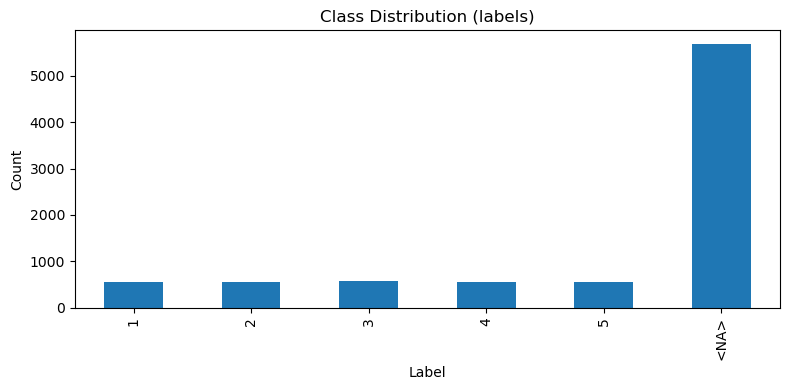

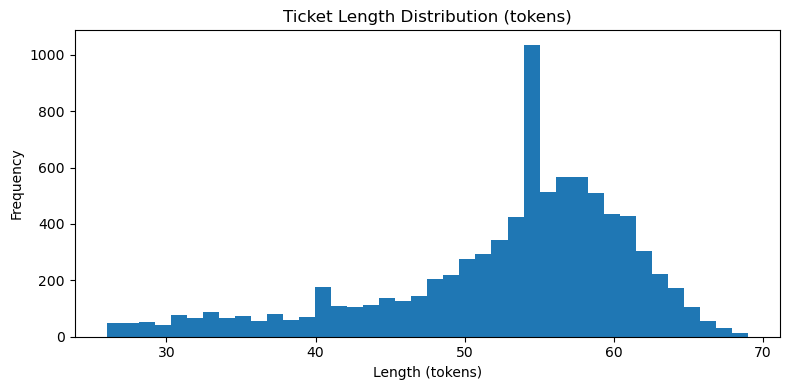

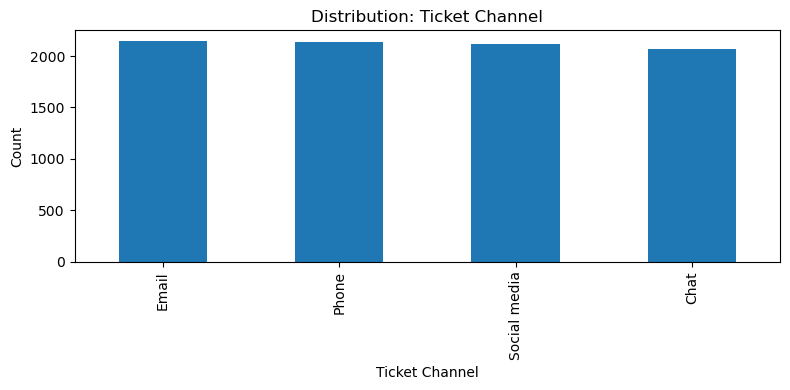

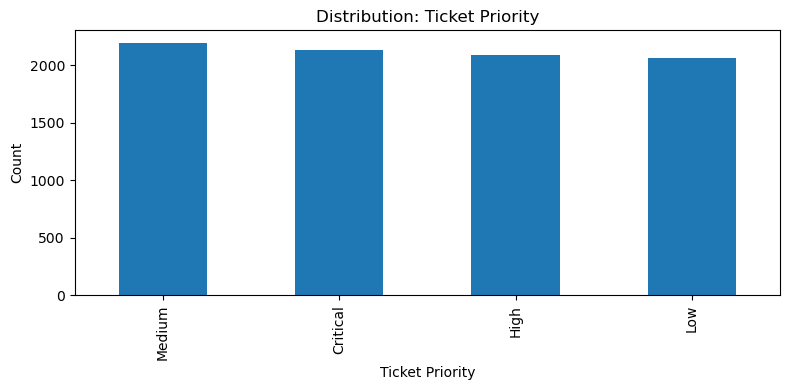

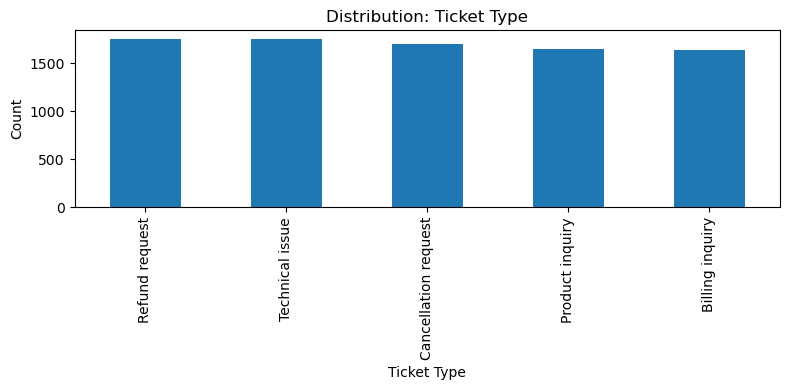

label,1,2,3,4,5,<NA>
Ticket Channel,,,,,,
Chat,125,120,149,134,146,1399
Email,148,155,132,145,140,1423
Phone,149,136,140,131,135,1441
Social media,131,138,159,133,123,1437


label,1,2,3,4,5,<NA>
Ticket Priority,,,,,,
Critical,152,146,149,138,141,1403
High,147,142,140,128,148,1380
Low,119,127,124,149,125,1419
Medium,135,134,167,128,130,1498


In [5]:

## EDA — distributions and quick insights

# 1) Class distribution bar plot
cls_counts = df_proc['label'].value_counts().sort_index()
plt.figure(figsize=(8,4))
cls_counts.plot(kind='bar')
plt.title('Class Distribution (labels)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2) Ticket length distribution (in tokens)
lengths = df_proc['text'].str.split().map(len)
plt.figure(figsize=(8,4))
plt.hist(lengths, bins=40)
plt.title('Ticket Length Distribution (tokens)')
plt.xlabel('Length (tokens)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 3) If available: distribution by a few categorical columns that may correlate
for cat_col in ['Ticket Channel', 'Ticket Priority', 'Ticket Type']:
    if cat_col in df.columns:
        plt.figure(figsize=(8,4))
        df[cat_col].fillna('NA').value_counts().head(20).plot(kind='bar')
        plt.title(f'Distribution: {cat_col}')
        plt.xlabel(cat_col)
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

# 4) Quick label vs. channel/priority counts (top bins only)
for cat_col in ['Ticket Channel', 'Ticket Priority']:
    if cat_col in df.columns:
        cross = pd.crosstab(df[cat_col].fillna('NA'), df_proc['label'])
        display(cross.head(10))


In [6]:

## Train/valid split (stratified)
X = df_proc['text'].values
y = df_proc['label'].values

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print('Train size:', len(y_train), 'Valid size:', len(y_valid))


Train size: 6775 Valid size: 1694



=== LinearSVC_bal ===
Accuracy: 0.5531
Macro F1: 0.1577 Weighted F1: 0.5078

Per-class metrics:
               precision    recall  f1-score   support

           1       0.06      0.04      0.05       111
           2       0.04      0.02      0.03       110
           3       0.04      0.03      0.03       116
           4       0.08      0.06      0.06       108
           5       0.06      0.04      0.05       109
        <NA>       0.67      0.81      0.73      1140

    accuracy                           0.55      1694
   macro avg       0.16      0.16      0.16      1694
weighted avg       0.47      0.55      0.51      1694

Confusion Matrix:
 [[  4   3   5   4   6  89]
 [  3   2   7   9   6  83]
 [  9   1   3   8   2  93]
 [  5   1   5   6   5  86]
 [  2   3   7   1   4  92]
 [ 43  39  48  50  42 918]]


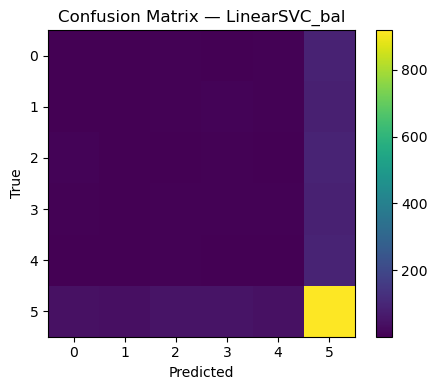


=== LogReg_bal ===
Accuracy: 0.3158
Macro F1: 0.1613 Weighted F1: 0.3728

Per-class metrics:
               precision    recall  f1-score   support

           1       0.08      0.14      0.10       111
           2       0.07      0.11      0.09       110
           3       0.07      0.14      0.09       116
           4       0.09      0.17      0.11       108
           5       0.05      0.10      0.07       109
        <NA>       0.68      0.41      0.51      1140

    accuracy                           0.32      1694
   macro avg       0.17      0.18      0.16      1694
weighted avg       0.48      0.32      0.37      1694

Confusion Matrix:
 [[ 15  12   9  12  12  51]
 [ 11  12  16  20  19  32]
 [ 15  10  16  12   9  54]
 [ 12   7  15  18  15  41]
 [ 16  17  17  11  11  37]
 [128 114 153 134 148 463]]


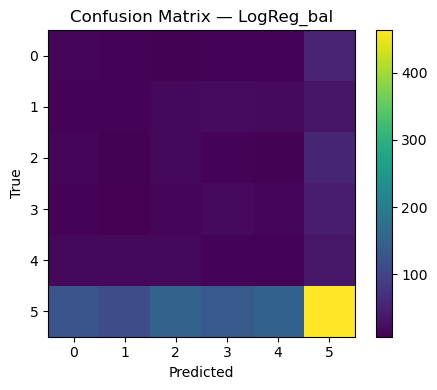


=== SGD_hinge_bal ===
Accuracy: 0.4481
Macro F1: 0.1645 Weighted F1: 0.4603

Per-class metrics:
               precision    recall  f1-score   support

           1       0.06      0.08      0.07       111
           2       0.07      0.07      0.07       110
           3       0.05      0.06      0.06       116
           4       0.09      0.11      0.10       108
           5       0.04      0.04      0.04       109
        <NA>       0.67      0.63      0.65      1140

    accuracy                           0.45      1694
   macro avg       0.16      0.17      0.16      1694
weighted avg       0.47      0.45      0.46      1694

Confusion Matrix:
 [[  9   7   6   9   8  72]
 [  8   8  11  11   8  64]
 [ 15   3   7   9   6  76]
 [  4   2  11  12   8  71]
 [  9  14  10   7   4  65]
 [ 95  82  92  86  66 719]]


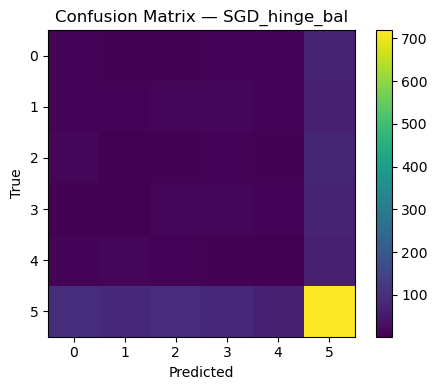


Best baseline so far: SGD_hinge_bal {'name': 'SGD_hinge_bal', 'accuracy': 0.44805194805194803, 'macro_f1': np.float64(0.16447664160369221), 'weighted_f1': np.float64(0.4603493459330514)}


In [7]:

## Features and models

# TF‑IDF: word and char, larger feature spaces
word_vect = ('word', TfidfVectorizer(
    ngram_range=(1,3),
    min_df=2,
    max_features=120_000,
    sublinear_tf=True,
))

char_vect = ('char', TfidfVectorizer(
    analyzer='char',
    ngram_range=(2,6),
    min_df=2,
    max_features=120_000,
    sublinear_tf=True,
))

features = FeatureUnion([word_vect, char_vect])

def evaluate_model(name, model, X_tr, y_tr, X_va, y_va):
    pipe = Pipeline([('feats', features), ('clf', model)])
    pipe.fit(X_tr, y_tr)
    preds = pipe.predict(X_va)
    acc  = accuracy_score(y_va, preds)
    macro_f1 = f1_score(y_va, preds, average='macro', zero_division=0)
    weighted_f1 = f1_score(y_va, preds, average='weighted', zero_division=0)
    print(f'\n=== {name} ===')
    print('Accuracy:', round(acc, 4))
    print('Macro F1:', round(macro_f1, 4), 'Weighted F1:', round(weighted_f1, 4))
    print('\nPer-class metrics:\n', classification_report(y_va, preds, zero_division=0))
    cm = confusion_matrix(y_va, preds)
    print('Confusion Matrix:\n', cm)
    # Plot CM
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion Matrix — {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    return pipe, {'name': name, 'accuracy': acc, 'macro_f1': macro_f1, 'weighted_f1': weighted_f1}

candidates = [
    ('LinearSVC_bal', LinearSVC(random_state=RANDOM_STATE, class_weight='balanced')),
    ('LogReg_bal', LogisticRegression(max_iter=3000, solver='saga', class_weight='balanced')),
    ('SGD_hinge_bal', SGDClassifier(loss='hinge', random_state=RANDOM_STATE, max_iter=3000, tol=1e-3, class_weight='balanced')),
]

results = []
best = None
for name, clf in candidates:
    pipe, metrics = evaluate_model(name, clf, X_train, y_train, X_valid, y_valid)
    results.append(metrics)
    if best is None or metrics['macro_f1'] > best['metrics']['macro_f1']:
        best = {'name': name, 'pipe': pipe, 'metrics': metrics}

print('\nBest baseline so far:', best['name'], best['metrics'])


In [8]:

## Optional simple oversampling (minority classes)
def simple_oversample(X_arr, y_arr, random_state=RANDOM_STATE):
    # Upsample each class to the size of the majority class
    rng = np.random.default_rng(random_state)
    X_list, y_list = [], []
    counts = Counter(y_arr)
    max_n = max(counts.values())
    for cls, n in counts.items():
        idx = np.where(y_arr == cls)[0]
        need = max_n - n
        if need > 0:
            extra_idx = rng.choice(idx, size=need, replace=True)
            idx_all = np.concatenate([idx, extra_idx])
        else:
            idx_all = idx
        X_list.append(X_arr[idx_all])
        y_list.append(y_arr[idx_all])
    X_bal = np.concatenate(X_list)
    y_bal = np.concatenate(y_list)
    # Shuffle
    perm = rng.permutation(len(y_bal))
    return X_bal[perm], y_bal[perm]

USE_OVERSAMPLE = False  # set True to try oversampling
if USE_OVERSAMPLE:
    X_train, y_train = simple_oversample(X_train, y_train)
    print('Oversampled Train size:', len(y_train))


Fitting 5 folds for each of 30 candidates, totalling 150 fits


D:\Anaconda\envs\csat-312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best CV macro‑F1: 0.1753
Best params: {'clf__alpha': np.float64(0.0023885558178688604), 'clf__loss': 'hinge', 'feats__char__max_features': 120000, 'feats__char__ngram_range': (3, 6), 'feats__word__max_features': 60000, 'feats__word__ngram_range': (1, 3)}

=== FINAL Validation Report ===
Accuracy: 0.4014
Macro F1: 0.1557 Weighted F1: 0.4326

Per-class metrics:
               precision    recall  f1-score   support

           1       0.04      0.07      0.05       111
           2       0.04      0.03      0.03       110
           3       0.05      0.04      0.05       116
           4       0.09      0.17      0.12       108
           5       0.06      0.10      0.08       109
        <NA>       0.68      0.56      0.61      1140

    accuracy                           0.40      1694
   macro avg       0.16      0.16      0.16      1694
weighted avg       0.47      0.40      0.43      1694

Confusion Matrix:
 [[  8   5   7  14   9  68]
 [ 13   3  10  16  14  54]
 [ 20   6   5  10   6

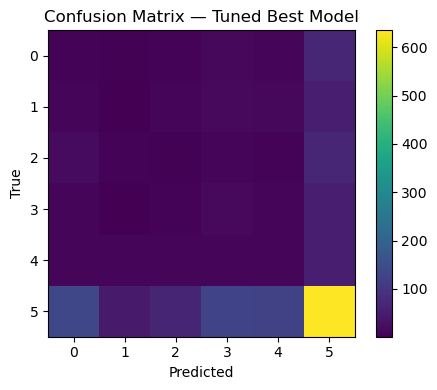

In [9]:

## Expanded hyperparameter search on the best model
from scipy.stats import loguniform, uniform

# Build a search space depending on the chosen best baseline
base = best['name']

param_distributions = {
    'feats__word__max_features': [60_000, 120_000],
    'feats__char__max_features': [60_000, 120_000],
    'feats__word__ngram_range': [(1,2), (1,3)],
    'feats__char__ngram_range': [(2,5), (2,6), (3,6)],
}

if base.startswith('LinearSVC'):
    param_distributions.update({
        'clf__C': loguniform(1e-2, 1e2),  # 0.01 to 100
    })
elif base.startswith('LogReg'):
    param_distributions.update({
        'clf__C': loguniform(1e-2, 1e2),
        'clf__penalty': ['l1', 'l2', 'elasticnet'],
        'clf__l1_ratio': uniform(0, 1),
    })
else:  # SGD
    param_distributions.update({
        'clf__alpha': loguniform(1e-6, 1e-2),
        'clf__loss': ['hinge', 'log_loss', 'modified_huber'],
    })

search = RandomizedSearchCV(
    estimator=best['pipe'],
    param_distributions=param_distributions,
    n_iter=30,
    scoring='f1_macro',
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    verbose=1,
    random_state=RANDOM_STATE,
)

search.fit(X_train, y_train)
print('Best CV macro‑F1:', round(search.best_score_, 4))
print('Best params:', search.best_params_)

# Final validation
preds = search.best_estimator_.predict(X_valid)
print('\n=== FINAL Validation Report ===')
print('Accuracy:', round(accuracy_score(y_valid, preds), 4))
print('Macro F1:', round(f1_score(y_valid, preds, average="macro", zero_division=0), 4),
      'Weighted F1:', round(f1_score(y_valid, preds, average="weighted", zero_division=0), 4))
print('\nPer-class metrics:\n', classification_report(y_valid, preds, zero_division=0))
cm = confusion_matrix(y_valid, preds)
print('Confusion Matrix:\n', cm)

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix — Tuned Best Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.tight_layout()
plt.show()


In [10]:

## Misclassification explorer — see top mistakes
def show_mistakes(X_va, y_va, y_pred, max_rows=15):
    rows = []
    for i, (t, y_t, y_p) in enumerate(zip(X_va, y_va, y_pred)):
        if y_t != y_p:
            rows.append({'true': y_t, 'pred': y_p, 'text': t[:300]})
        if len(rows) >= max_rows:
            break
    return pd.DataFrame(rows)

# Build a small frame of errors
y_pred_final = search.best_estimator_.predict(X_valid)
mistakes_df = show_mistakes(X_valid, y_valid, y_pred_final, max_rows=20)
mistakes_df


,true,pred,text
0,1,<NA>,refund request i m having an issue with the product purchased please assist we just need to know more about this product sleight of hand black pearl 4 99 sleight of hand i ve followed online tutor...
1,<NA>,4,payment issue i m encountering a software bug in the product purchased whenever i try to perform a specific action the application crashes are there any updates or fixes available not really at le...
2,1,<NA>,installation support i m having an issue with the product purchased please assist you ll get an auto purchase for both items we will not be selling any items at this time i ve already contacted cu...
3,<NA>,3,installation support i m having an issue with the product purchased please assist thank you for helping me to get my order in there as well as to people who have purchased from me on sale via ebay...
4,2,3,product compatibility i m having an issue with the product purchased please assist in addition to my own account info and email you must also tell me what s going on here on reddit and why i shoul...
5,<NA>,4,display issue i m having an issue with the product purchased please assist item id 1 the product purchased is required to provide a return label which indicates if this product is i ve tried diffe...
6,<NA>,4,display issue i m having an issue with the product purchased please assist you re on your way to work a number of companies are trying to make their software easier but they re asking for trouble ...
7,2,<NA>,product setup i m having an issue with the product purchased please assist 2 a month at 4 a month i ve tried clearing the cache and data for the product purchased app but the issue persists
8,1,2,network problem i m having an issue with the product purchased please assist 4 your account will be refunded please send a small email to i ve already contacted customer support multiple times but...
9,<NA>,3,battery life i m having an issue with the product purchased please assist we can now move on the user then asked for further documentation this user an elderly mother of four from seattle and resi...


In [11]:

## Save the tuned pipeline
import joblib
os.makedirs('artifacts', exist_ok=True)
joblib.dump(search.best_estimator_, 'artifacts/csat_text_pipeline_tuned.joblib')
print('Saved pipeline to artifacts/csat_text_pipeline_tuned.joblib')


Saved pipeline to artifacts/csat_text_pipeline_tuned.joblib
